In [34]:
import json
import re
import pandas as pd
from datascience import *
%matplotlib inline

In [75]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r', encoding='utf-8')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

In [122]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

In [123]:
match_html_path = './Manchester United 1-1 Burnley - Premier League 2023_2024 Live.html'
json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

In [124]:
players_df.head()

,playerId,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId
0,260843,24,André Onana,GK,190,93,28,True,False,home,"{'totalSaves': {'0': 1.0, '26': 1.0, '34': 1.0...",NaN,NaN,NaN,NaN,NaN,NaN,32
1,331924,29,Aaron Wan-Bissaka,DR,183,72,26,True,False,home,"{'possession': {'0': 2.0, '5': 1.0, '13': 2.0,...",NaN,NaN,NaN,NaN,NaN,NaN,32
2,88526,18,Casemiro,DC,185,84,32,True,False,home,"{'possession': {'0': 2.0, '1': 3.0, '2': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,32
3,99487,5,Harry Maguire,DC,194,90,31,True,False,home,"{'possession': {'1': 1.0, '5': 3.0, '8': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,32
4,353418,20,Diogo Dalot,DL,183,76,25,True,False,home,"{'possession': {'4': 1.0, '9': 2.0, '11': 1.0,...",NaN,NaN,NaN,NaN,NaN,NaN,32


In [125]:
def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df["receiver"] = df["playerId"].shift(-1)

    # filter only passes
    passes_ids = df.index[df['eventType'] == 'Pass']
    df_passes = df.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_passes
passes_df = get_passes_df(events_dict)
#passes_df.head()
passes_df

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
2,2.678794e+09,50.1,49.7,26.4,40.7,184,371447.0,362426.0,Pass,Successful
3,2.678794e+09,28.0,40.4,75.2,77.9,184,362426.0,88526.0,Pass,Unsuccessful
4,2.678795e+09,20.2,17.6,26.0,14.9,32,88526.0,364315.0,Pass,Successful
5,2.678795e+09,26.0,14.9,20.9,15.1,32,364315.0,331924.0,Pass,Successful
7,2.678795e+09,21.3,15.1,53.0,39.4,32,331924.0,362826.0,Pass,Unsuccessful
...,...,...,...,...,...,...,...,...,...,...
1478,2.679007e+09,53.0,78.4,85.9,11.9,184,362426.0,99487.0,Pass,Unsuccessful
1484,2.679007e+09,45.0,5.9,22.7,37.0,184,402874.0,362426.0,Pass,Successful
1485,2.679007e+09,19.2,37.1,34.9,30.6,184,362426.0,273292.0,Pass,Successful
1486,2.679007e+09,43.0,28.0,46.0,33.3,184,273292.0,123761.0,Pass,Unsuccessful


In [126]:
import pandas as pd

# Assuming passes_df is your DataFrame containing pass data

# Define conditions
x_condition = (passes_df['x'] >= 1)
endX_condition = (passes_df['endX'] <= 45)

# Filter passes_df
defensepasses_df = passes_df[x_condition & endX_condition]

# Display the filtered DataFrame
defensepasses_df.head()


,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
2,2.678794e+09,50.1,49.7,26.4,40.7,184,371447.0,362426.0,Pass,Successful
4,2.678795e+09,20.2,17.6,26.0,14.9,32,88526.0,364315.0,Pass,Successful
5,2.678795e+09,26.0,14.9,20.9,15.1,32,364315.0,331924.0,Pass,Successful
22,2.678796e+09,53.9,11.5,42.9,36.9,32,88526.0,99487.0,Pass,Successful
23,2.678796e+09,42.3,25.4,44.4,7.6,32,99487.0,88526.0,Pass,Successful


In [127]:
def get_passes_between_df(team_id, passes_df, players_df):
    # filter for only team
    passes_df = passes_df[passes_df["teamId"] == team_id]

    # add column with first eleven players only
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df = (passes_df.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # Filter to include only players who have made 2 or more passes between themselves
    passes_between_df = passes_between_df[passes_between_df['pass_count'] >= 4]

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df, average_locs_and_count_df


In [128]:
home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(home_team_id, defensepasses_df, players_df)

In [129]:
away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(away_team_id, defensepasses_df, players_df)

In [130]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from mplsoccer import Pitch, FontManager

In [131]:
def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, flipped=False):
    MAX_LINE_WIDTH = 10
    MAX_MARKER_SIZE = 3000
    MIN_FONT_SIZE = 8
    
    # Calculate line width and marker size
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() * MAX_LINE_WIDTH)
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count'] / average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)
    
    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#507293'))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency
    
    pitch = Pitch(pitch_type='opta', pitch_color='WHITE', line_color='#507293')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df['x'] = pitch.dim.right - passes_between_df['x']
        passes_between_df['y'] = pitch.dim.right - passes_between_df['y']
        passes_between_df['x_end'] = pitch.dim.right - passes_between_df['x_end']
        passes_between_df['y_end'] = pitch.dim.right - passes_between_df['y_end']
        average_locs_and_count_df['x'] = pitch.dim.right - average_locs_and_count_df['x']
        average_locs_and_count_df['y'] = pitch.dim.right - average_locs_and_count_df['y']

    pass_lines = pitch.lines(passes_between_df.x, passes_between_df.y,
                             passes_between_df.x_end, passes_between_df.y_end, lw=passes_between_df.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df.x, average_locs_and_count_df.y,
                               s=average_locs_and_count_df.marker_size,
                               color='RED', edgecolor='#507293', linewidth=1, alpha=1, ax=ax)
    
    # Calculate font size for player initials based on marker size
    max_marker_size = average_locs_and_count_df['marker_size'].max()
    font_size = 14 * (average_locs_and_count_df['marker_size'] / max_marker_size)
    
    # Apply minimum font size
    font_size = np.maximum(font_size, MIN_FONT_SIZE)
    
    # Annotate player initials
    for index, row in average_locs_and_count_df.iterrows():
        player_name = row["name"].split()
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_initials, xy=(row.x, row.y), c='BLACK', va='center',
                       ha='center', size=font_size[index], ax=ax)

    return pitch


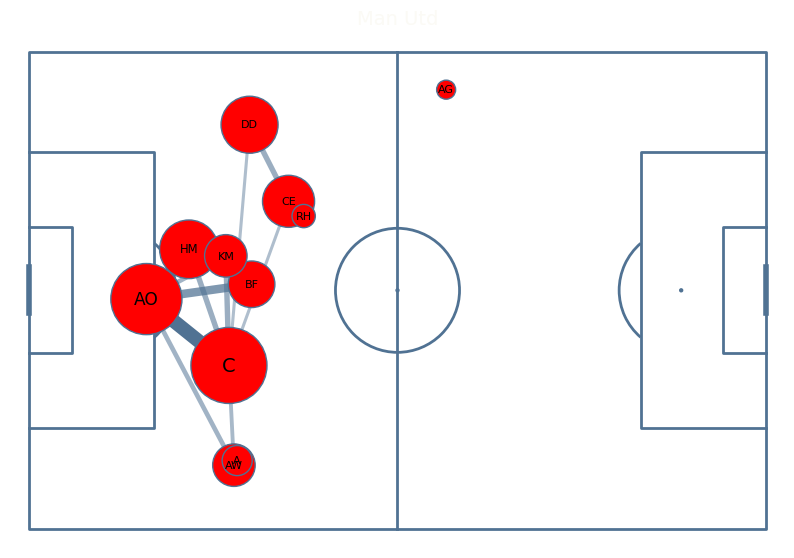

In [134]:
fig, ax = plt.subplots(figsize=(10, 8))  # Use a single subplot for the home team

# plot variables
main_color = '#FBFAF5'

# home team viz
pass_network_visualization(ax, home_passes_between_df, home_average_locs_and_count_df)

# Set title for the home team
ax.set_title(teams_dict[home_team_id], color=main_color, fontsize=14)

# Set suptitle and subtitle

# Save the image with the home team name as filename
plt.savefig(f"{teams_dict[home_team_id]}_vs_{teams_dict[away_team_id]}_{teams_dict[home_team_id]}_def_passing_network.png", bbox_inches='tight')

plt.show()


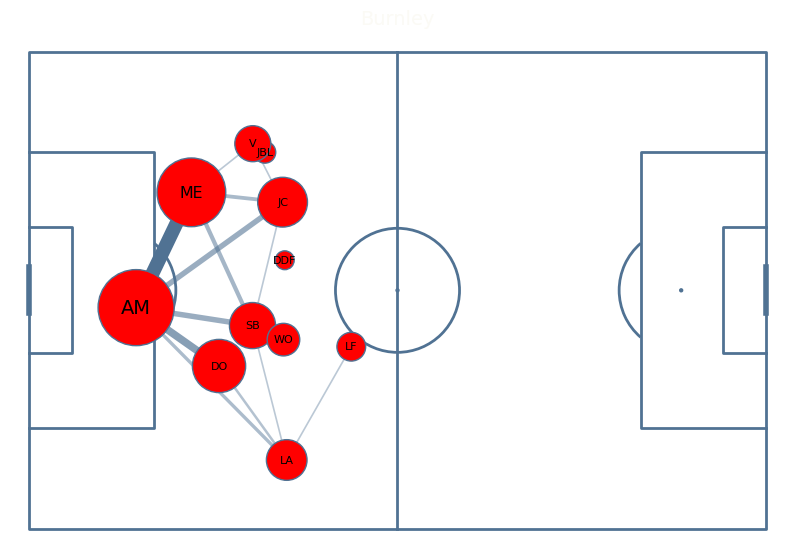

In [136]:
fig, ax = plt.subplots(figsize=(10, 8))  # Use a single subplot for the home team

# plot variables
main_color = '#FBFAF5'

# home team viz
pass_network_visualization(ax, away_passes_between_df, away_average_locs_and_count_df)

# Set title for the home team
ax.set_title(teams_dict[away_team_id], color=main_color, fontsize=14)

# Set suptitle and subtitle

# Save the image with the home team name as filename
plt.savefig(f"{teams_dict[home_team_id]}_vs_{teams_dict[away_team_id]}_{teams_dict[away_team_id]}_def_passing_network.png", bbox_inches='tight')
plt.show()
